En aquest quadern classificarem els tumors en benignes o malignes en funció dels paràmetres continguts a la base de dades Breast Cancer Wisconsin.

Seguim el llibre de Sebastian Raschka i Vahid Mirjalili **Python Machine Learning**.

1. Començarem llegint el conjunt de dades directament des del lloc web de la UCI amb `pandas`.

In [ ]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',header=None)


2. A continuació, assignam les 30 característiques a una matriu X de NumPy. Amb un objecte `LabelEncoder`, transformam les etiquetes de classe des de la seva representació de cadena original ('M' i 'B', per a maligne i benigne respectivament) en els enters 1 i 0.

In [ ]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

3. Després de codificar les etiquetes de classe, que són els diagnòstics, en una matriu, els tumors malignes ('M') es representen ara com a classe 1 i els benignes ('B') com a classe 0. Podem comprovar aquesta transformació invocant el mètode transform de l'objecte ajustat LabelEncoder amb les dues etiquetes de classe possibles.

In [ ]:
le.transform(['M','B'])

array([1, 0])

Tot seguit, dividim el conjunt de dades en una part d'entrenament (el 80%) i una altra de prova, de test (l'altre 20%).

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

Ara construim la cadena de transformacions formada per escalat, anàlisi de 8 components principals (PCA) i finalment regressió logística.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components=8),
    LogisticRegression(random_state=1)
)

pipe_lr.fit(X_train, y_train)

score_train = pipe_lr.score(X_train, y_train)
score_test = pipe_lr.score(X_test,y_test)

print('Train accuracy: %.3f' % score_train)
print('Test accuracy: %.3f' % score_test)

Train accuracy: 0.985
Test accuracy: 0.982


# Validació creuada k-fold per avaluar el rendiment del model

A la validació creuada k-fold, dividim el conjunt de dades d'entrenament aleatòriament en $k$ plegaments (*folds*) sense reemplaçament; $k-1$ parts s'utilitzaran per entrenar i la restant per a l'avaluació de rendiment. El procediment es repeteix $k$ vegades, de forma que s'obtenen $k$ models i estimacions de precisió.

Una lleugera millora sobre el procediment estàndard de validació creuada s'aconsegueix amb la validació creuada k-fold estratificada. Aquesta variant aconsegueix millors estimacions del biaix i la variància, especialment en casos de proporcions de classe desiguals.

A la validació creuada k-fold estratificada, les proporcions d'etiqueta de classe es mantenen en cada plegament per assegurar que cada plegament sigui representatiu de les proporcions de classe del conjunt d'entrenament.

Ho il·lustram a continuació mitjançant l'ús de l'iterador **StratifiedKFold** de **scikit-learn**.

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []

for k, (train, test) in enumerate(kfold):
  pipe_lr.fit(X_train[train], y_train[train])
  score = pipe_lr.score(X_train[test], y_train[test])
  scores.append(score)
  print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

Fold:  1, Class dist.: [256 153], Acc: 0.978
Fold:  2, Class dist.: [256 153], Acc: 0.978
Fold:  3, Class dist.: [256 153], Acc: 1.000
Fold:  4, Class dist.: [256 153], Acc: 0.978
Fold:  5, Class dist.: [256 153], Acc: 0.957
Fold:  6, Class dist.: [257 153], Acc: 0.933
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 1.000
Fold:  9, Class dist.: [257 153], Acc: 1.000
Fold: 10, Class dist.: [257 153], Acc: 0.978


Vegem a continuació la mitjana i desviació estàndard de les puntuacions.

In [ ]:
print('\nCV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))


CV accuracy: 0.978 +/- 0.020


També podem avaluar la validació creuada k-fold amb la funció **cross_val_score** implementat a scikit-learn, d'un forma més concisa. El resultat que s'obté al final és el mateix.

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [0.97826087 0.97826087 1.         0.97826087 0.95652174 0.93333333
 0.97777778 1.         1.         0.97777778]


In [ ]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.978 +/- 0.020


# Corbes d'aprenentatge i validació

##Corba d'aprenentatge

La corba d'aprenentatge representa l'exactitud (*accuracy*) en funció de la mida del conjunt d'entrenament.

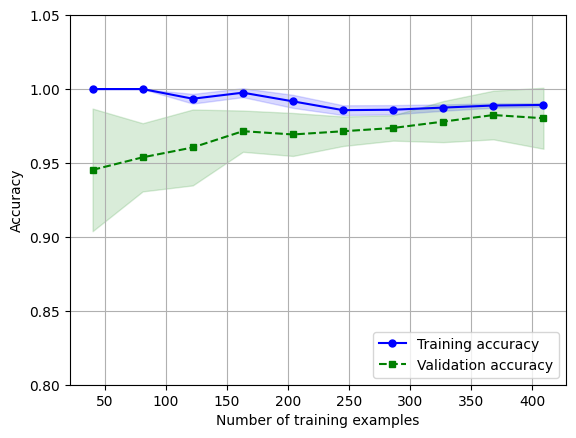

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2',
                                           random_state=1,
                                           solver='lbfgs',
                                           max_iter=10000))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1,1.0,10),
                                                        cv=10,
                                                        n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes,
         train_mean,
         color='blue',
         marker='o',
         markersize=5,
         label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15,
                 color='blue')

plt.plot(train_sizes,
         test_mean,
         color='green',
         linestyle='--',
         marker='s',
         markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15,
                 color='green')

plt.grid()

plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.05])
plt.show()

## Corba de validació

La corba de validació representa l'exactitud en els conjunts d'entrenament i de validació respecte del valor de l'hiperparàmetre que volem optimitzar.

El valor òptim de l'hiperparàmetre és el que coincideix amb el màxim de l'exactitud de **validació**. A la gràfica de baix, $C=1$.

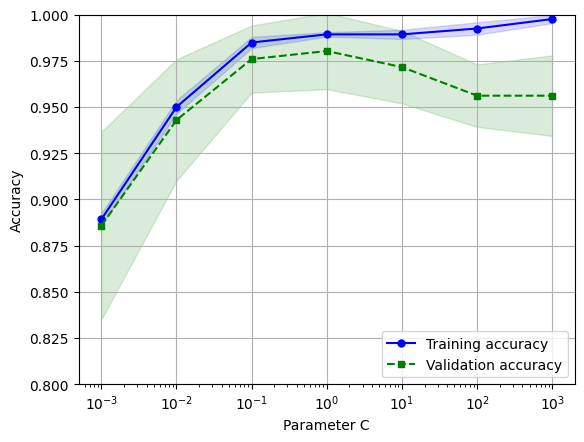

In [ ]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                             X=X_train,
                                             y=y_train,
                                             param_name='logisticregression__C',
                                             param_range=param_range,
                                             cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range,
         train_mean,
         color='blue',
         marker='o',
         markersize=5,
         label='Training accuracy')

plt.fill_between(param_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15,
                 color='blue')

plt.plot(param_range,
         test_mean,
         color='green',
         linestyle='--',
         marker='s',
         markersize=5,
         label='Validation accuracy')

plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15,
                 color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()


# Ajust d'hiperparàmetres amb cerca en xarxa

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [ {'svc__C': param_range,
                'svc__kernel': ['linear']},
               {'svc__C': param_range,
                'svc__kernel': ['rbf'],
                'svc__gamma': param_range}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  refit=True,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)



Una vegada hem optimitzat i entrenat el millor model, vegem la seva exactitud sobre el conjunt d'entrenament i els paràmetres seleccionats.

In [ ]:
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


Finalment, hem d'avaluar l'exactitud del model sobre el conjunt separat de test.

In [ ]:
print('Test accuracy: %.4f' % gs.score(X_test, y_test))

Test accuracy: 0.9737


# Mètriques d'avaluació del rendiment

## Matriu de confusió

La matriu de confusió és una matriu quadrada que mostra el recompte dels veritables positius (TP), veritables negatius (TN), falsos positius (FP) i falsos negatius (FN).


In [ ]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test,
                           y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


En aquest exemple, els valors són:

TP = 71

FN = 1

FP = 2

TN = 40

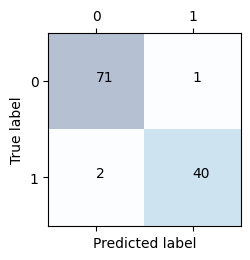

In [ ]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j,
            y=i,
            s=confmat[i, j],
            )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Precisió i reclam (*recall*) als models de classificació

Tant l'error de predicció (ERR) com l'exactitud o *accuracy* (ACC) donen informació general sobre quants d'exemples estan mal classificats. Les seves expressions són les següents.

$$ERR=\frac{FP+FN}{FP+FN+TP+TN}$$

$$ACC=\frac{TP+TN}{FP+FN+TP+TN} = 1 - ERR$$

Les taxes de falsos positius i veritables positius es defineixen així:

$$FPR = \frac{FP}{FP+TN}$$

$$TPR = \frac{TP}{FN+TP}$$

A partir dels recomptes de positius i negatius, es defineixen la precisió (*precision*) i el reclam (recall) de la forma següent.

$$ PRE = \frac{TP}{TP+FP} $$

$$ REC = \frac{TP}{FN+TP} $$

Per equilibrar la influència d'aquestes dues mesures, sovint s'utilitza la seva mitjana harmònica.

$$F_1 = 2\frac{PRE\times REC}{PRE+REC} $$

En Python,



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976


In [ ]:
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))

Recall: 0.952


Per defecte, la classe positiva a **scikit-learn** és la classe etiquetada com a $1$.

Si volem especificar una etiqueta positiva distinta, podem construir el nostre propi scorer amb la funció make_scorer, que es pot passar directament com a paràmetre **scoring** a la funció **GridSearchCV** (en aquest exemple, usant **f1_score** com a mètrica).

In [ ]:
from sklearn.metrics import make_scorer, f1_score

c_gamma_range=[0.01, 0.1, 1.0, 10.0]

param_grid=[{'svc__C': c_gamma_range,
             'svc__kernel': ['linear']},
            {'svc__C': c_gamma_range,
             'svc__gamma': c_gamma_range,
             'svc__kernel': ['rbf']}]

scorer = make_scorer(f1_score, pos_label=0)

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10)

gs = gs.fit(X_train, y_train)

In [ ]:
print(gs.best_score_)

0.9861994953378878


In [ ]:
print(gs.best_params_)

{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


# ROC: Receiver Operating Characteristic

Els gràfics de Receiver Operating Characteristic (ROC) són eines útils per triar models de classificació segons les taxes FPR i TPR, que es calculen desplaçant el llindar de decisió del classificador.

La diagonal del gràfic ROC es pot interpretar com una decisió a l'atzar, i els models per baix de la diagonal són pitjors que decidir a l'atzar. Un classificador perfecte seria al racó de dalt a l'esquerra, amb $TPR=1$ i $FPR=0$.

A partir de la corba ROC, es calcula l'àrea sota la corba (**AUC**, *Area Under the Curve*), que caracteritza el rendiment d'un model de classificació. El valor òptim ideal és $AUC=1$.

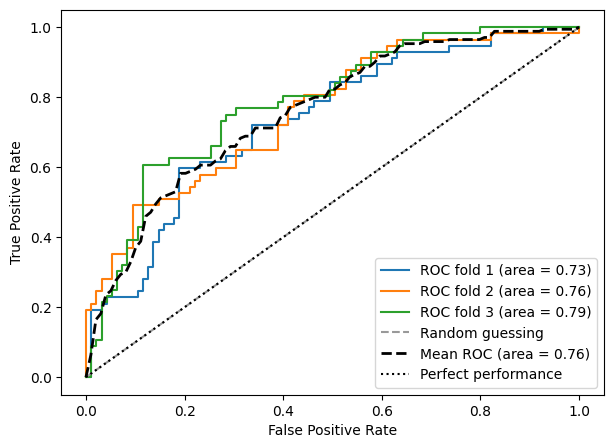

In [ ]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2',
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0))
X_train2 = X_train[:, [4, 14]]

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
  probas = pipe_lr.fit(
      X_train2[train],
      y_train[train]).predict_proba(X_train2[test])
  fpr, tpr, threshold = roc_curve(y_train[test],
                                  probas[:,1],
                                  pos_label=1)
  mean_tpr += np.interp(mean_fpr, fpr, tpr)
  mean_tpr[0] = 0.0
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr,
           tpr,
           label='ROC fold %d (area = %0.2f)' % (i+1,roc_auc))

plt.plot([0, 1],
        [0, 1],
        linestyle='--',
        color=(0.6, 0.6, 0.6),
        label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1],
         [0, 0, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

